In [1]:
import h5py
import numpy as np
from keras.models import *
from keras.applications import *
from keras.preprocessing.image import *
import matplotlib.pyplot as plt
import os
import cv2

D:\ProgramData\Anaconda3\envs\tf36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Build model:

In [2]:
# base model
base_model = Xception(weights='imagenet', include_top=False)

# top layers
# x = GlobalAveragePooling2D()(base_model.output)
top_model = load_model('Xception_top_weights.h5')
activation_weights = top_model.layers[-1].get_weights()


In [3]:
print(activation_weights[0].shape, activation_weights[1].shape)

(2048, 1) (1,)


### Predict:

In [26]:
img = load_img('test/test/1000.jpg', target_size=(299, 299))
img = img_to_array(img)
x = np.expand_dims(img, axis=0)
x = xception.preprocess_input(x)
feature_map = base_model.predict(x)


In [27]:
print(feature_map.shape)

(1, 10, 10, 2048)


In [28]:
feature_map = np.squeeze(feature_map)
pred = np.average(feature_map, axis=(0, 1))
pred = np.matmul(pred, activation_weights[0]) + activation_weights[1]
pred = 1 / (1 +  np.e ** (-pred))

In [29]:
print(pred)

[0.9993094]


### Class Activation Map:

In [30]:
cam = (pred - 0.5) * np.matmul(feature_map, activation_weights[0])
cam = (cam - cam.min()) / (cam.max() - cam.min())
cam = cv2.resize(cam, (299, 299))
cam = 255 * cam
cam = cam.astype(np.uint8)


In [31]:
print(cam.shape)

(299, 299)


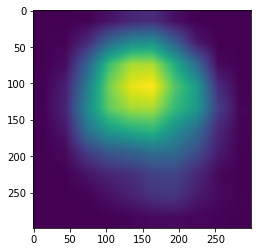

In [32]:
plt.imshow(cam)

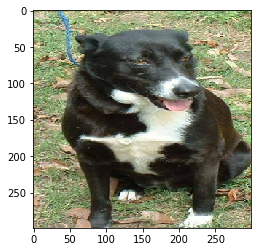

In [33]:
img = load_img('test/test/1000.jpg', target_size=(299, 299))
img = img_to_array(img).astype(np.uint8)
plt.imshow(img)

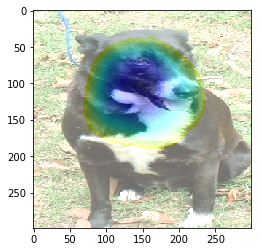

In [34]:
heat_threshold = 100
heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
heatmap[np.where(cam <= heat_threshold)] = 255

# overlapping: alpha*src1 + beta * src2 + gamma
out = cv2.addWeighted(src1=img, alpha=0.8, src2=heatmap, beta=0.4, gamma=0)

plt.imshow(out)